In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
x = np.loadtxt("I.txt")

In [3]:
x.shape

(1001, 500)

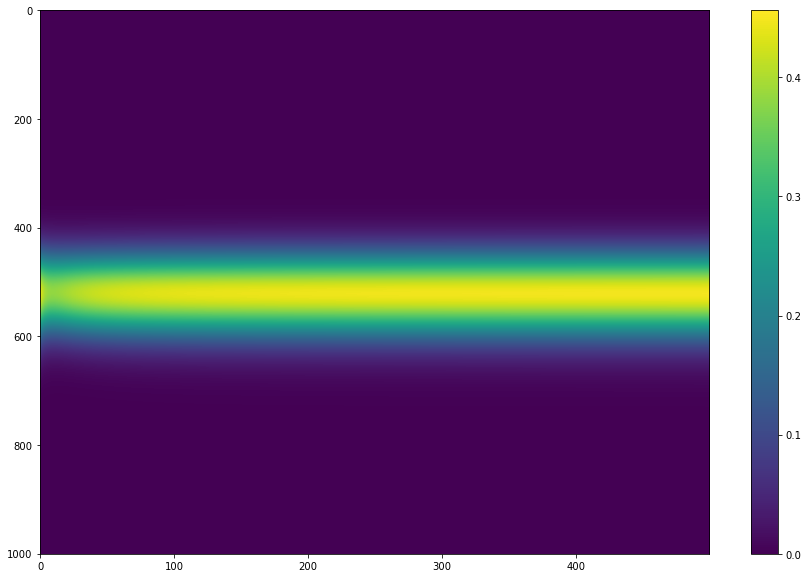

In [4]:
plt.figure(figsize=(15,10))
plt.imshow(x, aspect="auto")
plt.colorbar()

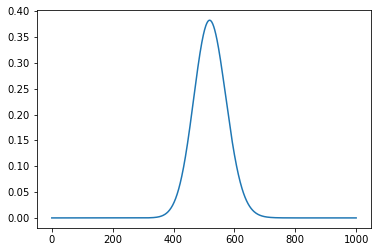

In [5]:
plt.plot(x[:,8])

In [6]:
y = np.loadtxt("output.txt")

In [7]:
y.shape

(20020, 64)

In [8]:
y = y.reshape(1001,20,64)

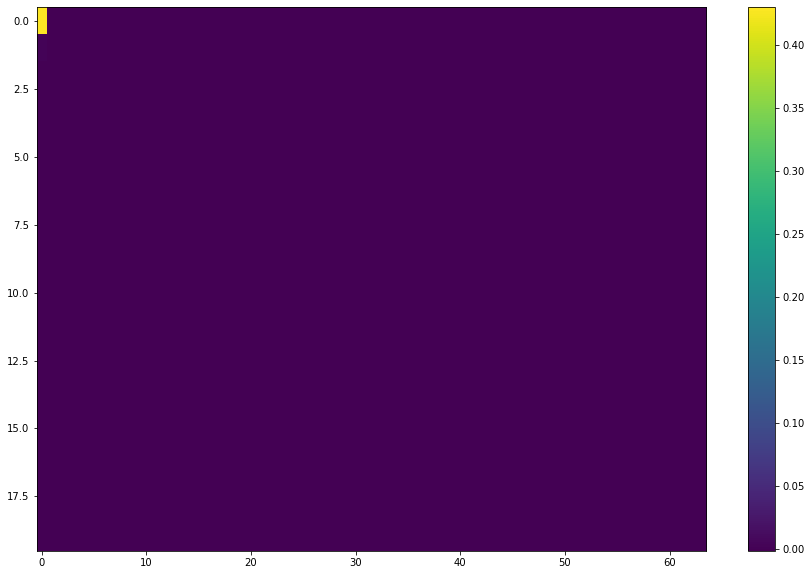

In [9]:
plt.figure(figsize=(15,10))
plt.imshow(y[10], aspect="auto")
plt.colorbar()

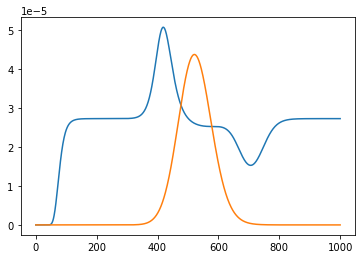

In [10]:
plt.plot(y[:,4,30])
plt.plot(x[:,4*25]/10000)

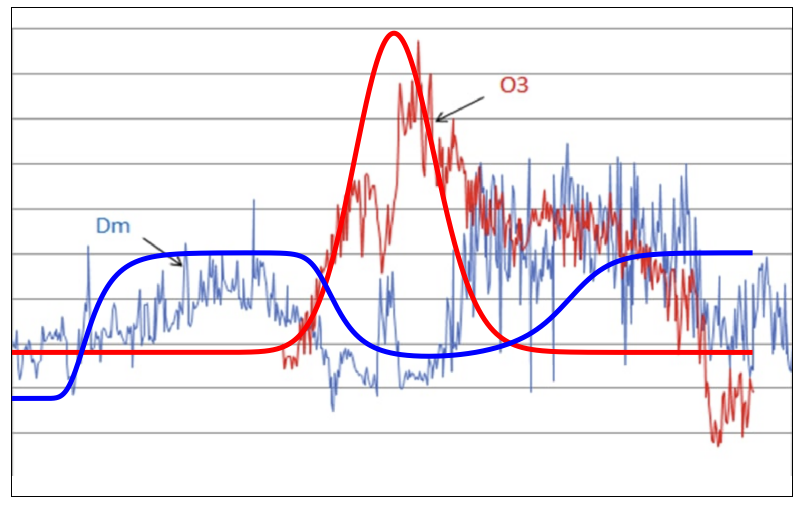

In [40]:
img = plt.imread("ozon.png")
val = 7
sizes = y[:,val,:]*np.linspace(1,64,64)
fig, ax1 = plt.subplots(figsize=(14,9))

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.plot(np.linspace(-10,1600,1001), sizes.mean(axis=1), color='blue', label="Dm", lw=5)
ax2.plot(np.linspace(-10,1600,1001), x[:,val*25]/200, color='red', label="ОЗ", lw=5)
ax2.set_yticks([])
ax3.set_yticks([])
ax2.set_ylim(-0.001,0.0024)
ax3.set_ylim(-0.001,0.004)
ax1.set_yticks([])
ax2.set_xticks([])
ax1.imshow(img)
plt.savefig("map.jpg")


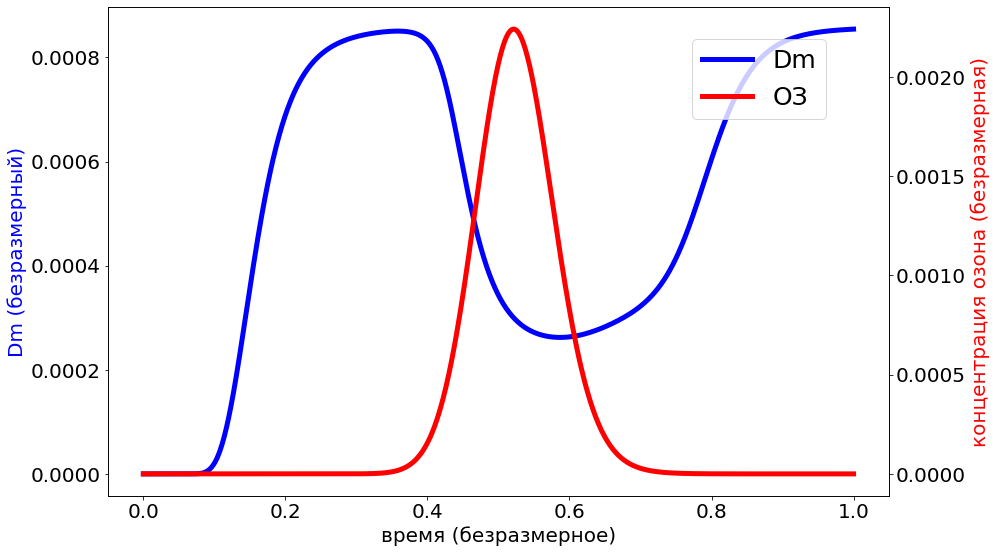

In [12]:
#val = 8
val = 15

sizes = y[:,val,:]*np.linspace(1,64,64)
#plt.figure(figsize=(13,9))
fig, ax1 = plt.subplots(figsize=(14,9))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax2 = ax1.twinx()
ax1.plot(np.linspace(0,1,1001), sizes.mean(axis=1), color='blue', label="Dm", lw=5)
ax2.plot(np.linspace(0,1,1001), x[:,val*25]/200, color='red', label="ОЗ", lw=5)

ax1.set_xlabel("время (безразмерное)", fontsize=20)
ax1.set_ylabel("Dm (безразмерный)", fontsize=20, color='blue')
ax2.set_ylabel("концентрация озона (безразмерная)", fontsize=20, color='red')

fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.yticks(fontsize=20)
plt.xticks(fontsize=40)
plt.savefig("num_ozon.jpg")


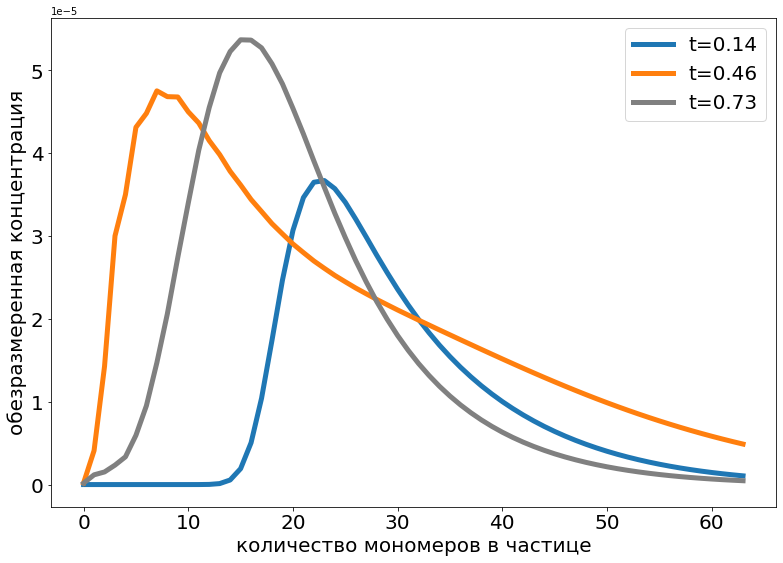

In [13]:
#plt.plot(y[400,9,:], label="400")
plt.figure(figsize=(13,9))
v1 =145
v2 = 463
v3 = 726
#230,430,900
plt.plot(y[v1,val,:], label="t="+str(round(v1*0.001,2)), lw=5)
plt.plot(y[v2,val,:], label="t="+str(round(v2*0.001,2)), lw=5)
plt.plot(y[v3,val,:], color='grey',label="t="+str(round(v3*0.001,2)), lw=5)
plt.ylabel("обезразмеренная концентрация", fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("количество мономеров в частице", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig("num_spectra.jpg")

In [184]:
val = 12
sizes = y[:,val,:]*np.linspace(1,32,32)

plt.figure()
plt.plot(sizes.mean(axis=1))
plt.plot(x[:,val]/100)
#plt.plot(y[400,9,:], label="400")
plt.figure()
plt.plot(y[200,val], label="100")
plt.plot(y[180,val], label="400")
plt.plot(y[90,val], color='grey',label="800")
plt.legend()

ValueError: operands could not be broadcast together with shapes (1000,128) (32,) 